This notebook looks at the total reads per sample, to respond to the following reviewer comment:

> Could the authors provide a table of paired end reads were assigned to each sample type? It allows readers to understand how many reads were assigned and to see if there is substantial differences between the oropharyngeal, lung, and gastric samples.

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import ranksums, ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
fmeta = '../../data/clean/rosen.metadata.clean'
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

In [3]:
outfile = '../../final/figures/suppfig.total_reads.png'

In [4]:
print(meta.shape)
# Remove the 05 and second time point samples
samples = meta.index.tolist()

# Don't include samples from second time point or lung transplants
exclude = ['2', 'F', 'sick', 'F2T']
for s in exclude:
    samples = [i for i in samples if not i.endswith(s)]
samples = [i for i in samples if not i.startswith('05')]

# The two others which are Aim 5 (lung transplant) patients
samples = [i for i in samples if not i.startswith('dup')]
samples = [i for i in samples if not i.startswith('15-169-4')] 

meta = meta.loc[samples]
print(meta.shape)

(455, 958)
(455, 958)


In [5]:
meta['log_reads'] = np.log10(meta['total_reads'])
# Fill nan's with a string so seaborn can plot
meta['mbs_consolidated'] = meta['mbs_consolidated'].fillna('nan')

In [6]:
order = ['bal', 'gastric_fluid', 'throat_swab', 'stool']

/Users/claire/anaconda/envs/aspiration/lib/python2.7/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


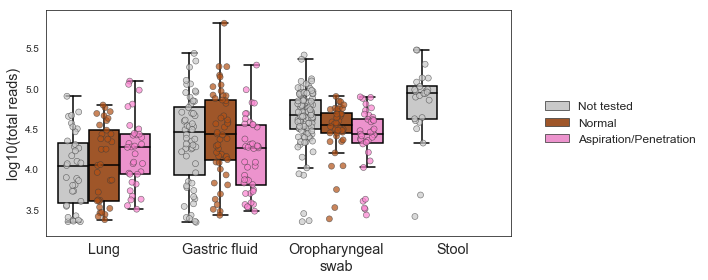

In [7]:
# Overall properties
asp_colors = {'Normal': '#B25116', 'Aspiration/Penetration': '#FB84D1', 'nan': '#C9C9C9'}

kwargs = {'palette': asp_colors,
          'hue_order': ['nan', 'Normal', 'Aspiration/Penetration']}

# Boxplot properties
boxprops = {'edgecolor': 'k'} #, #, 'facecolor': 'w'}
lineprops = {'color': 'k'} #, 'linewidth': 0.95}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops}, 
                      **kwargs)
# Stripplot properties
stripplot_kwargs = dict({'linewidth': 0.6, 'size': 6, 'alpha': 0.7}, 
                        **kwargs)

## Set up plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 4))

sns.boxplot(x='site', y='log_reads', data=meta,
            order=order, hue='mbs_consolidated',
            fliersize=0, **boxplot_kwargs)
sns.stripplot(x='site', y='log_reads', data=meta,
              order=order, hue='mbs_consolidated',
              split=True, jitter=0.2, 
              **stripplot_kwargs)


# Edit labels, etc
ax.set_ylabel('log10(total reads)', fontsize='x-large')
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_xticklabels(['Lung',
                   'Gastric fluid',
                   'Oropharyngeal\nswab',
                   'Stool'],
                  fontsize='x-large')

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles[0:3], 
                ['Not tested', 'Normal', 'Aspiration/Penetration'], 
              #loc=(0, 0), 
              loc='center left', 
              fontsize='large',
              bbox_to_anchor=(1.05, 0.5), 
              frameon=False)
lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [40]

fig.tight_layout()
fig.savefig(outfile, dpi=200)

## P values

The reviewer asked for differences between sites (but what matters, imo, is differences within a site between aspirator and non-aspirator). Let's do both.

In [8]:
# Between sites
for s1 in order:
    for s2 in order[order.index(s1)+1:]:
        x = meta.query('site == @s1')['total_reads'].tolist()
        y = meta.query('site == @s2')['total_reads'].tolist()
        print(s1, s2, ranksums(x, y))

('bal', 'gastric_fluid', RanksumsResult(statistic=-3.4651506754851997, pvalue=0.0005299344833078597))
('bal', 'throat_swab', RanksumsResult(statistic=-7.839565359277953, pvalue=4.521085891415743e-15))
('bal', 'stool', RanksumsResult(statistic=-5.783884402432068, pvalue=7.2995112250301955e-09))
('gastric_fluid', 'throat_swab', RanksumsResult(statistic=-4.222693017458245, pvalue=2.4140051272730723e-05))
('gastric_fluid', 'stool', RanksumsResult(statistic=-4.432855934523154, pvalue=9.299300617540084e-06))
('throat_swab', 'stool', RanksumsResult(statistic=-3.9470996612205873, pvalue=7.910363498122251e-05))


As expected, these are different. But that's expected because of the different biomass of samples.

The thing that might confound results more concerningly would be if there's differences between aspirators and non-aspirators.

In [9]:
asp = 'Aspiration/Penetration'
nml = 'Normal'
for s, subdf in meta.groupby('site'):
    x = subdf.query('mbs_consolidated == @asp')['total_reads'].tolist()
    y = subdf.query('mbs_consolidated == @nml')['total_reads'].tolist()
    
    print(s, ranksums(x, y))

('bal', RanksumsResult(statistic=1.070842889530781, pvalue=0.2842400784683218))
('gastric_fluid', RanksumsResult(statistic=-2.2964713122102958, pvalue=0.02164894762091057))
('rectal_swab', RanksumsResult(statistic=nan, pvalue=nan))
('stool', RanksumsResult(statistic=nan, pvalue=nan))
('throat_swab', RanksumsResult(statistic=-1.752185788881901, pvalue=0.07974186645815227))


/Users/claire/anaconda/envs/aspiration/lib/python2.7/site-packages/scipy/stats/stats.py:4971: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


In [10]:
# Does looking at log10(reads) change things?

for s, subdf in meta.groupby('site'):
    x = subdf.query('mbs_consolidated == @asp')['log_reads'].tolist()
    y = subdf.query('mbs_consolidated == @nml')['log_reads'].tolist()
    
    print(s, ttest_ind(x, y))

('bal', Ttest_indResult(statistic=1.1827576147031766, pvalue=0.24128053504555735))
('gastric_fluid', Ttest_indResult(statistic=-2.510328492296228, pvalue=0.013911704766968055))
('rectal_swab', Ttest_indResult(statistic=nan, pvalue=nan))
('stool', Ttest_indResult(statistic=nan, pvalue=nan))
('throat_swab', Ttest_indResult(statistic=-1.440899128698819, pvalue=0.15366742919964813))


Nope, both yield same results. Okay, let's just add into the limiations discussion.